In [115]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import datetime


In [116]:
interactiondata = pd.read_csv('../data/interactiondata.csv')
userdata = pd.read_csv('../data/userdata.csv')
orderdata = pd.read_csv('../data/orderdata.csv')

df = pd.merge(interactiondata, userdata, on='userid')

df['join_datetime'] = pd.to_datetime(df['join_datetime'])
df['last_order_dt'] = pd.to_datetime(df['last_order_dt'])
df['join_date'] = df['join_datetime'].dt.date

df['fish'] = np.zeros(len(df))
df['sweets'] = np.zeros(len(df))
df['fruits'] = np.zeros(len(df))
df['alcohol'] = np.zeros(len(df))
df['meat'] = np.zeros(len(df))
df['vegetables'] = np.zeros(len(df))
df['other'] = np.zeros(len(df))

df['sum_bill'] = np.zeros(len(df))

df['purchases']= df['catalogue_purchases_count_avg'] + df['store_purchases_count_avg'] + df['website_purchases_count_avg'] + df['mobile_purchases_count_avg'] 

df['marketing_company_outcome'] = df['marketing_company_outcome_1'] + df['marketing_company_outcome_2'] + df['marketing_company_outcome_3'] + df['marketing_company_outcome_4'] + df['marketing_company_outcome_5']
df['discount_percent'] = df.apply(lambda row: 0 if row['purchases'] == 0 else row['discount_purchases_count_avg'] / row['purchases'], axis=1)

df['kids_and_teenagers'] = df['kids'] + df['teenagers']

df['website_conversion'] = df['website_purchases_count_avg'] / df['website_visit_count_avg']
df['mobile_conversion'] = df['mobile_purchases_count_avg'] / df['mobile_visit_count_avg']

df['website_conversion'] = df.apply(lambda x: 0 if x['website_visit_count_avg'] == 0 else x['website_purchases_count_avg'] / x['website_visit_count_avg'], axis=1)
df['mobile_conversion'] = df.apply(lambda x: 0 if x['mobile_visit_count_avg'] == 0 else x['mobile_purchases_count_avg'] / x['mobile_visit_count_avg'], axis=1)

df['age_category'] = df['age' ] // 15

In [117]:
for index, row in orderdata.iterrows():
    userid = row['userid']
    category = row['category']
    price = row['avg_bill']

    df_index = df[df['userid'] == userid].index
    if not df_index.empty:
        scalar_index = df_index[0]
        if category == 'fish':
            df.at[scalar_index, 'fish'] = price
        elif category == 'sweets':
            df.at[scalar_index, 'sweets'] = price
        elif category == 'fruits':
            df.at[scalar_index, 'fruits'] = price
        elif category == 'alcohol':
            df.at[scalar_index, 'alcohol'] = price
        elif category == 'meat':
            if (np.isnan(price)):
                df.at[scalar_index, 'meat'] = 0
            else:
                df.at[scalar_index, 'meat'] = price
        elif category == 'vegetables':
            df.at[scalar_index, 'vegetables'] = price
        else:
            df.at[scalar_index, 'other'] = price
        
        df.at[scalar_index, 'sum_bill'] += price
            


In [118]:
# Чистим данные

income_5_percentile = df['income'].quantile(0.05)
income_95_percentile = df['income'].quantile(0.95)

df = df[(df['age'] <= 90) & (df['age'] >= 20)]
df = df[~((df['age'] < 18) & (df['marital'].isin(['divorced', 'married', 'widow'])))]
df = df[(df['income'] > income_5_percentile) & (df['income'] < income_95_percentile)]

In [150]:
def exponential_smoothing(series, alpha=0.3):
    result = series.copy()
    for i in range(len(series)):
        if i == 0:
            result.iloc[i] = series.iloc[i]
        else:
            result.iloc[i] = alpha * series.iloc[i] + (1 - alpha) * result.iloc[i - 1]
    return result

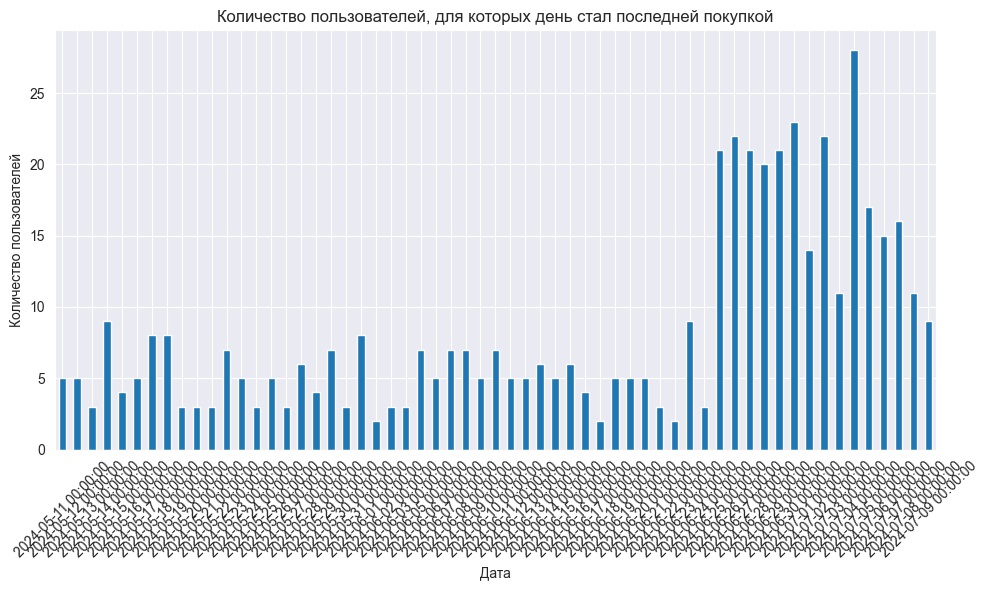

In [120]:
general_df = df
general_df['days_between'] = (general_df['last_order_dt'] - general_df['join_datetime']).dt.days
general_df = general_df[general_df['days_between'] <= 180]
data_for_plot = general_df.groupby('last_order_dt').size()


plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей, для которых день стал последней покупкой')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

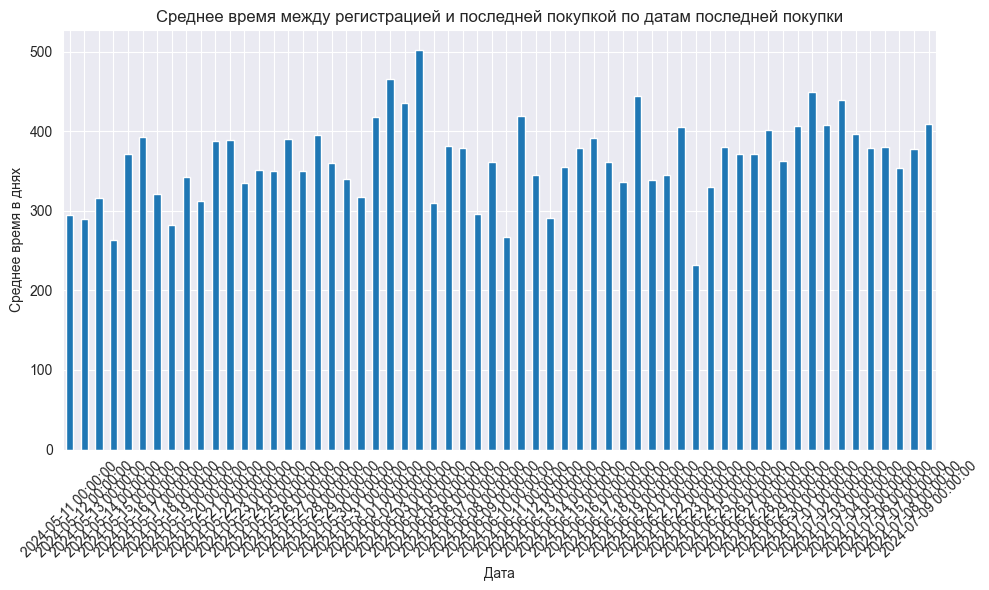

In [121]:
# Calculate the average days between registration and last purchase for each last purchase date
df['days_between'] = (df['last_order_dt'] - df['join_datetime']).dt.days
data_for_plot = df.groupby('last_order_dt')['days_between'].mean()

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.title('Среднее время между регистрацией и последней покупкой по датам последней покупки')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

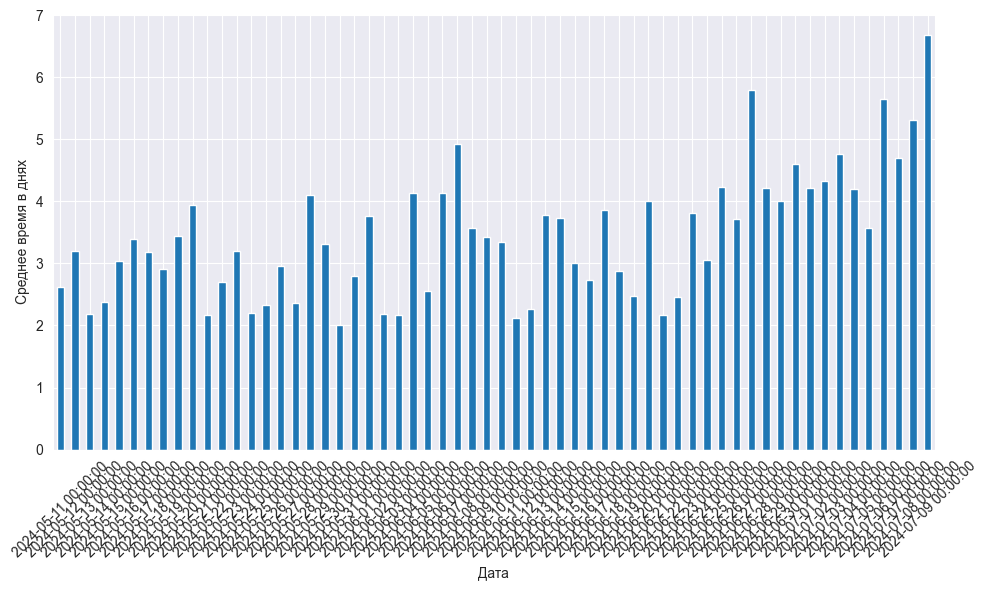

In [122]:
df_for_plot = df[(pd.to_datetime("2024.06.25") - df['join_datetime']).dt.days > 0]
data_for_plot = df_for_plot.groupby('last_order_dt')['discount_purchases_count_avg'].mean()

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

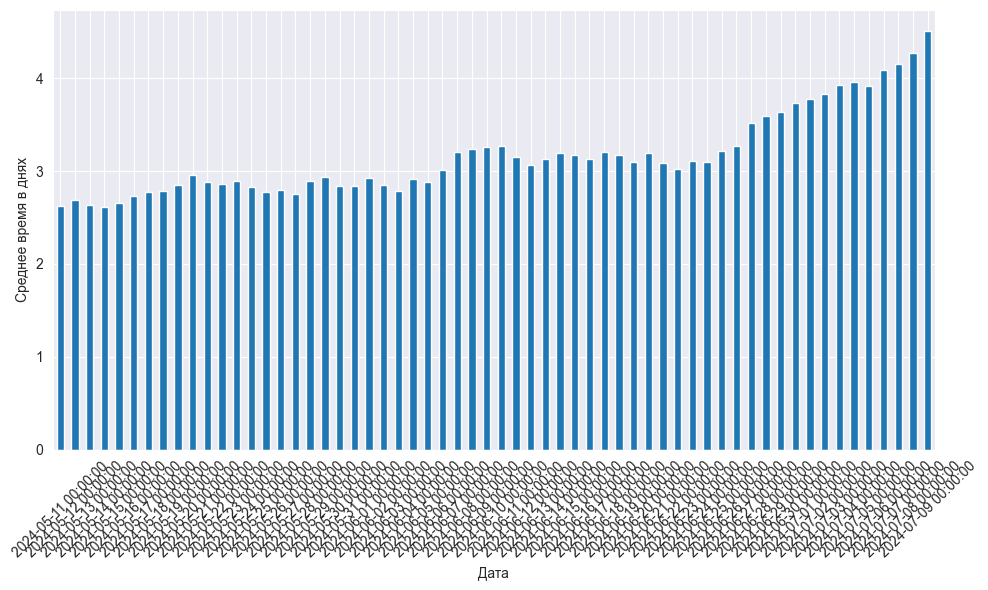

In [123]:
df_for_plot = df[(pd.to_datetime("2024.06.25") - df['join_datetime']).dt.days > 0]
data_for_plot = df_for_plot.groupby('last_order_dt')['discount_purchases_count_avg'].mean()
data_for_plot = exponential_smoothing(data_for_plot, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

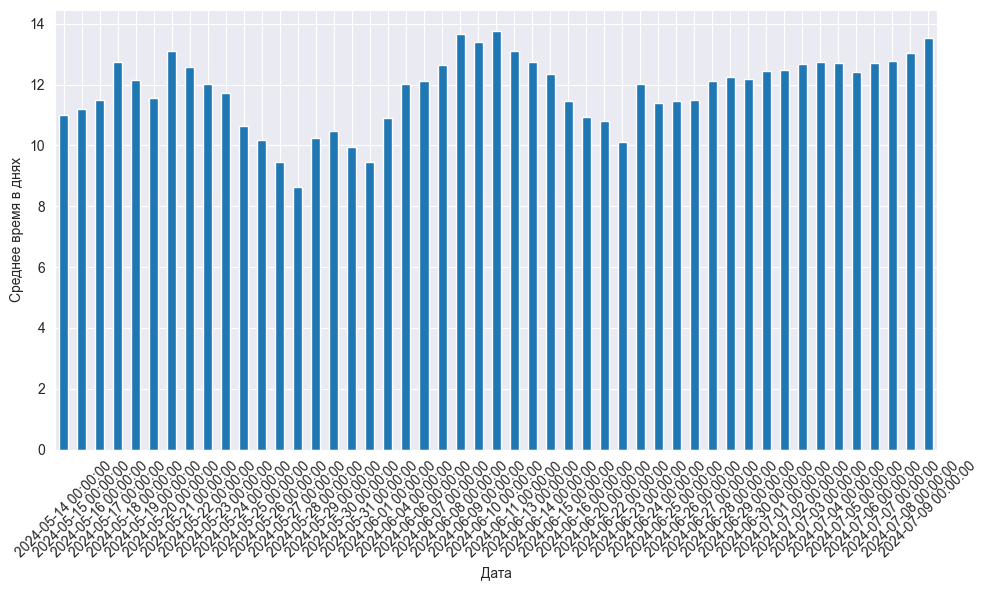

In [124]:
df_for_plot = df[df['age'] < 30]
data_for_plot = df_for_plot.groupby('last_order_dt')['discount_purchases_count_avg'].mean()
data_for_plot = exponential_smoothing(data_for_plot, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [125]:
young_df = df[df['age'] < 30]

before_june_25 = young_df[young_df['last_order_dt'] < '2024-06-25']['discount_purchases_count_avg']
after_june_25 = young_df[young_df['last_order_dt'] >= '2024-06-25']['discount_purchases_count_avg']

# Assuming the output of stats.shapiro is stored as (statistic, p_value)
shapiro_result_before = stats.shapiro(before_june_25)
shapiro_result_after = stats.shapiro(after_june_25)

print(f"Before June 25: Shapiro-Wilk test statistic = {shapiro_result_before[0]}, p-value = {shapiro_result_before[1]}")
if shapiro_result_before[1] > 0.05:
    print("Data before June 25 can be considered normally distributed (fail to reject H0).")
else:
    print("Data before June 25 cannot be considered normally distributed (reject H0).")

print(f"After June 25: Shapiro-Wilk test statistic = {shapiro_result_after[0]}, p-value = {shapiro_result_after[1]}")
if shapiro_result_after[1] > 0.05:
    print("Data after June 25 can be considered normally distributed (fail to reject H0).")
else:
    print("Data after June 25 cannot be considered normally distributed (reject H0).")

Before June 25: Shapiro-Wilk test statistic = 0.8943731852651176, p-value = 0.0001071778071581506
Data before June 25 cannot be considered normally distributed (reject H0).
After June 25: Shapiro-Wilk test statistic = 0.9465324246965393, p-value = 1.582371558156519e-08
Data after June 25 cannot be considered normally distributed (reject H0).


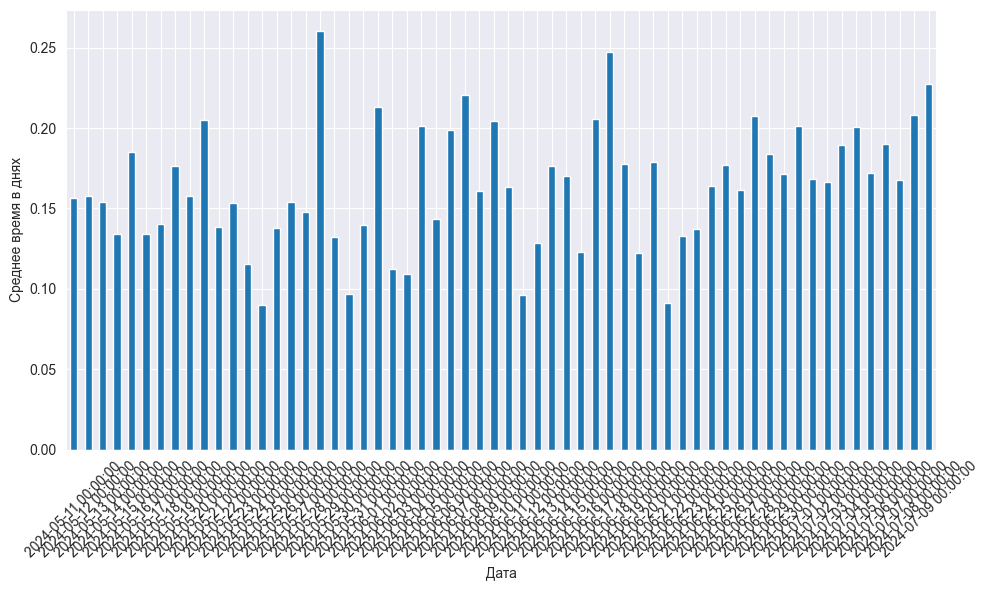

In [126]:
df_for_plot = df.copy()
df_for_plot['discount_percent'] = df_for_plot.apply(lambda row: 0 if row['purchases'] == 0 else row['discount_purchases_count_avg'] / row['purchases'], axis=1)
data_for_plot = df_for_plot.groupby('last_order_dt')['discount_percent'].mean()

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Количество дней между регистрацией и последней покупкой')

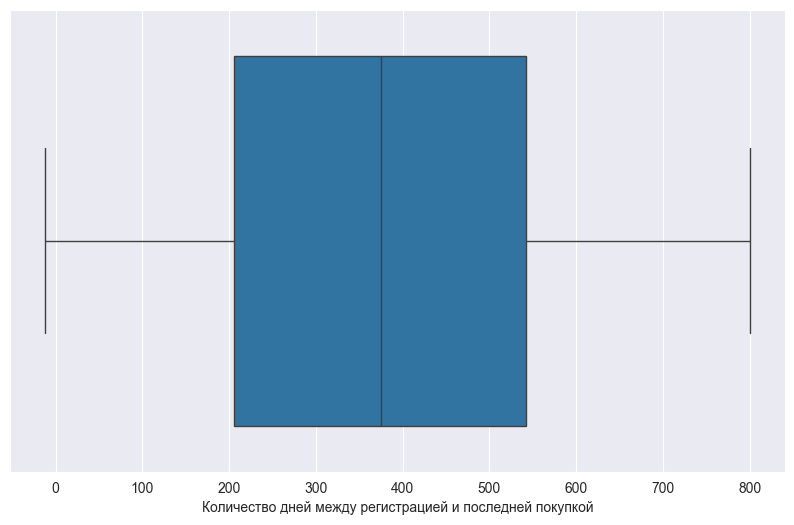

In [127]:
# добавим столбце с кол-вом дней прошелдших от регистрации 
df['days_between'] = (df['last_order_dt'] - df['join_datetime']).dt.days
# Построим боксплот
plt.figure(figsize=(10, 6))
sns.boxplot(x='days_between', data=df)
plt.xlabel('Количество дней между регистрацией и последней покупкой')


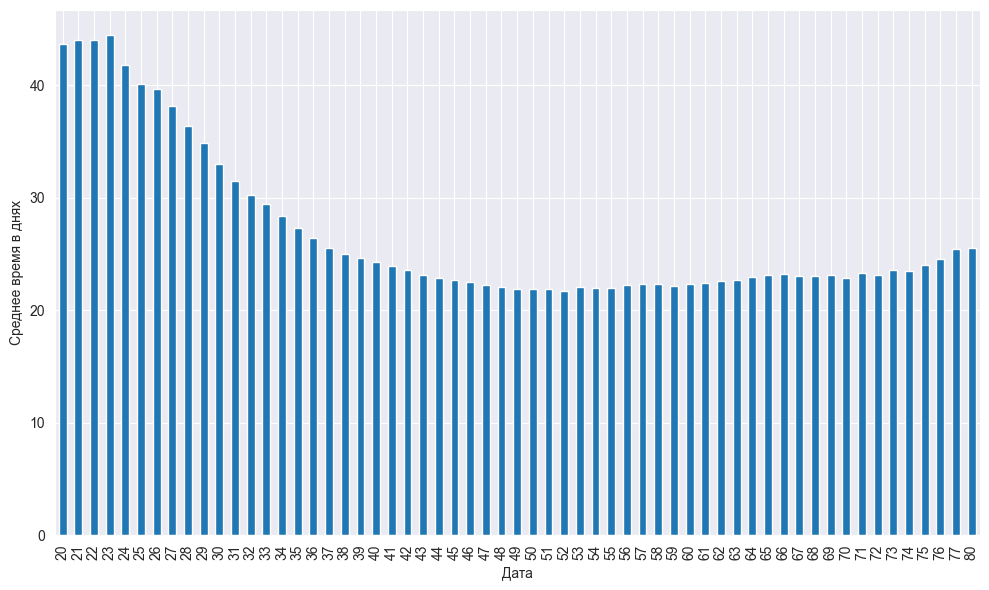

In [128]:
df_for_plot = df
data_for_plot = df_for_plot.groupby('age')['purchases'].mean()
data_for_plot = exponential_smoothing(data_for_plot, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.tight_layout()
plt.show()

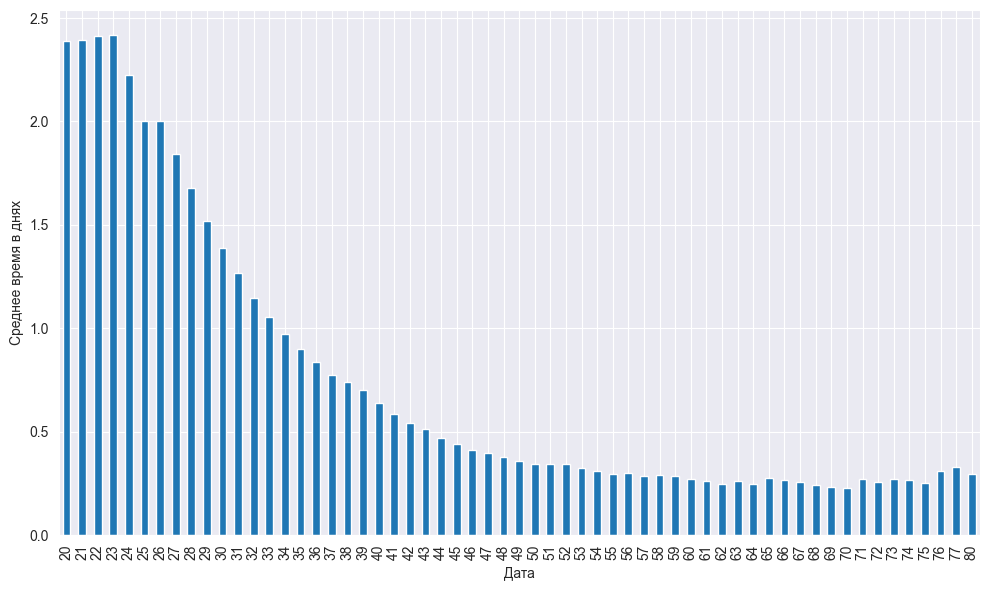

In [129]:
df_for_plot = df
data_for_plot = df_for_plot.groupby('age')['marketing_company_outcome'].mean()
data_for_plot = exponential_smoothing(data_for_plot, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.tight_layout()
plt.show()

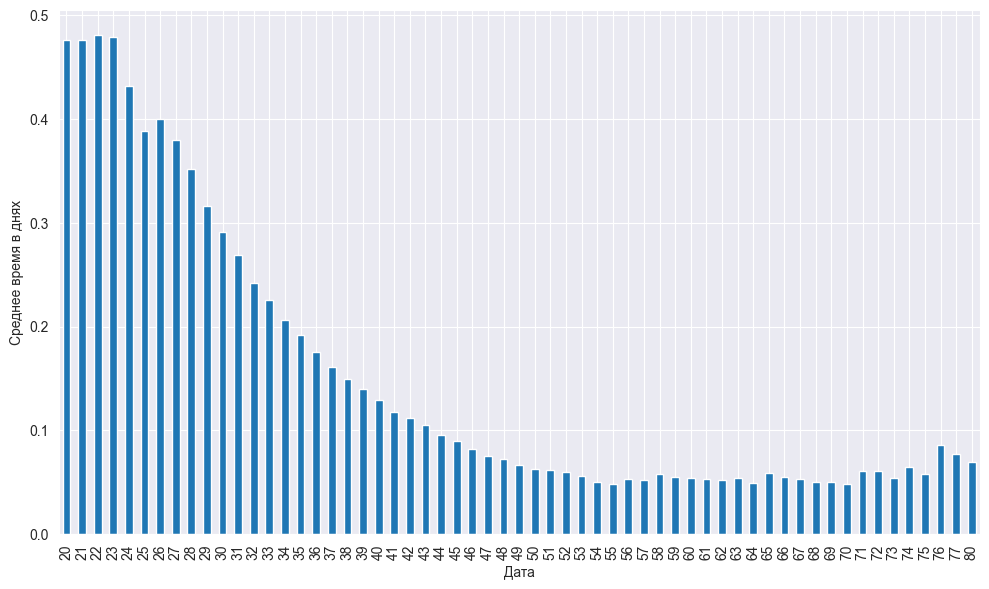

In [130]:
df_for_plot = df
data_for_plot = df_for_plot.groupby('age')['marketing_company_outcome_1'].mean()
data_for_plot = exponential_smoothing(data_for_plot, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.tight_layout()
plt.show()

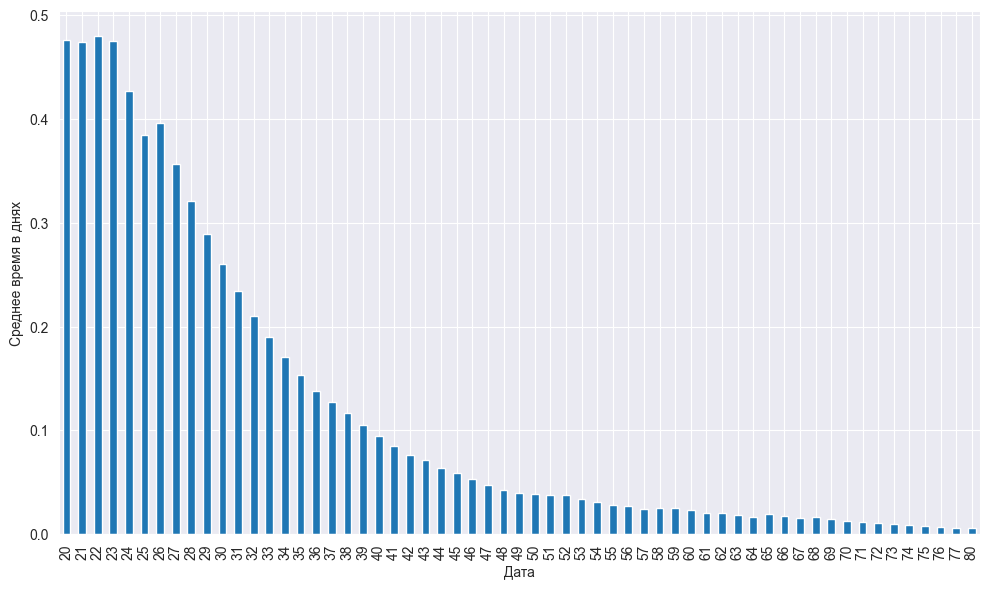

In [131]:
df_for_plot = df
data_for_plot = df_for_plot.groupby('age')['marketing_company_outcome_2'].mean()
data_for_plot = exponential_smoothing(data_for_plot, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.tight_layout()
plt.show()

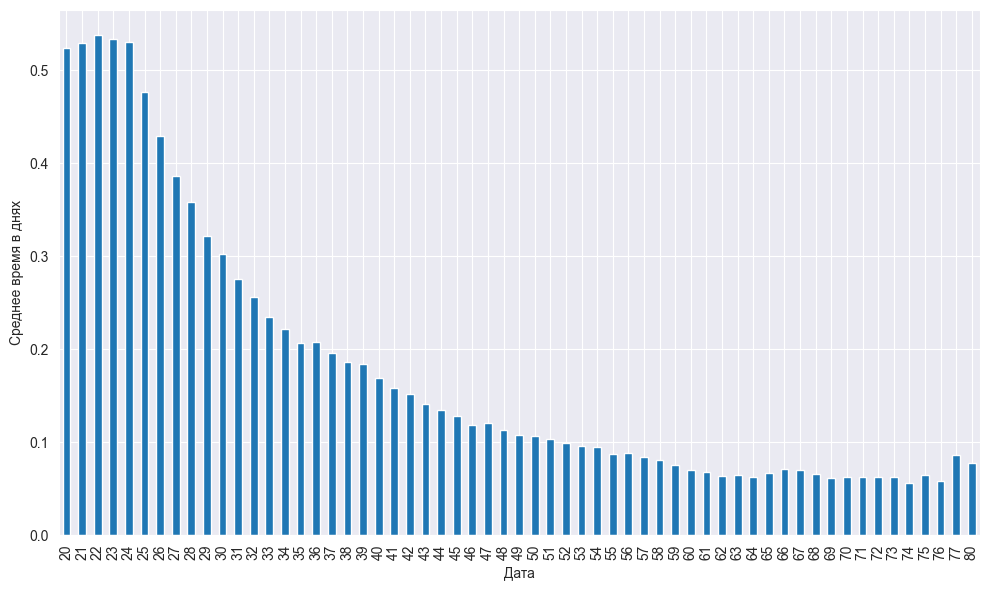

In [132]:
df_for_plot = df
data_for_plot = df_for_plot.groupby('age')['marketing_company_outcome_3'].mean()
data_for_plot = exponential_smoothing(data_for_plot, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.tight_layout()
plt.show()

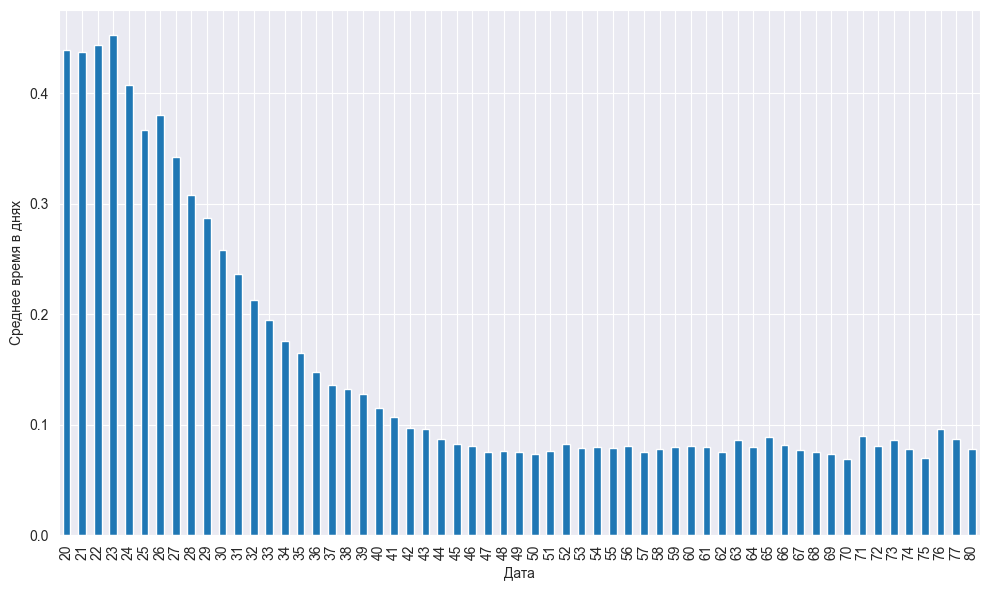

In [133]:
df_for_plot = df
data_for_plot = df_for_plot.groupby('age')['marketing_company_outcome_4'].mean()
data_for_plot = exponential_smoothing(data_for_plot, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.tight_layout()
plt.show()

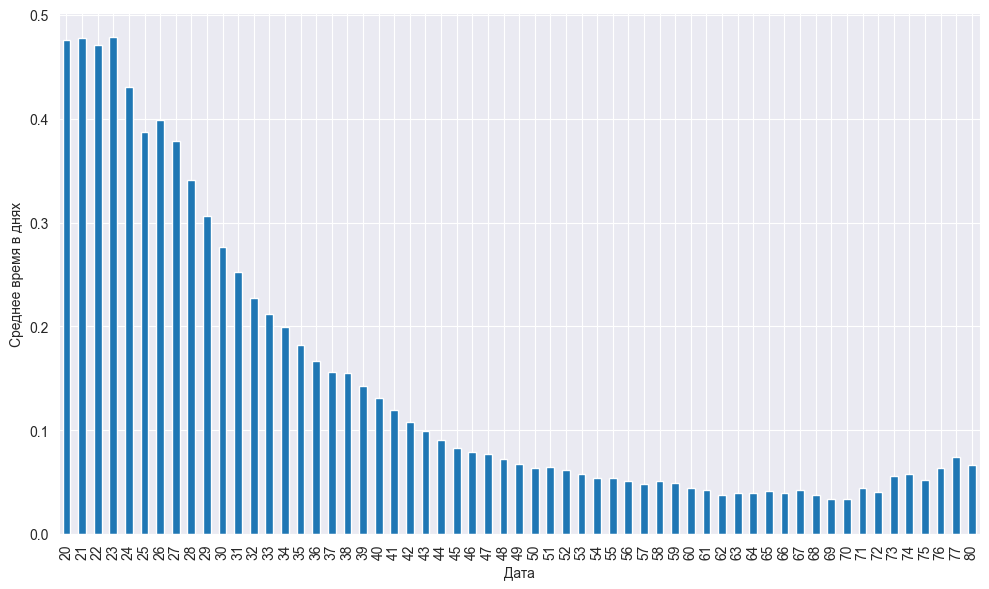

In [134]:
df_for_plot = df
data_for_plot = df_for_plot.groupby('age')['marketing_company_outcome_5'].mean()
data_for_plot = exponential_smoothing(data_for_plot, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.tight_layout()
plt.show()

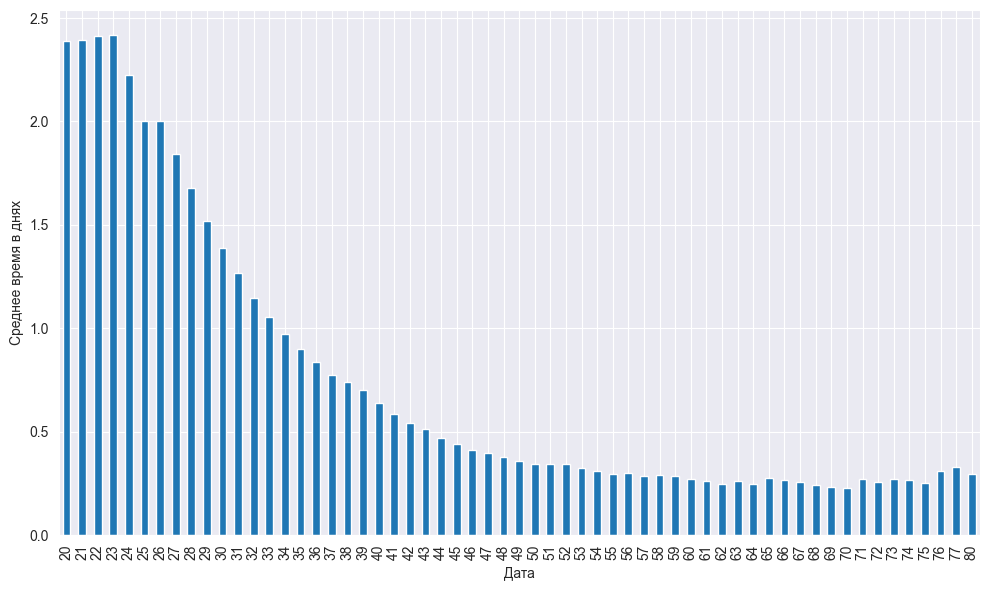

In [135]:
df_for_plot = df
data_for_plot = df_for_plot.groupby('age')['marketing_company_outcome'].mean()
data_for_plot = exponential_smoothing(data_for_plot, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.tight_layout()
plt.show()

In [136]:
correlation = df['marketing_company_outcome'].corr(df['discount_purchases_count_avg'])
print("Correlation coefficient:", correlation)

Correlation coefficient: 0.5715400296038189


In [137]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Assuming df is your DataFrame and it's already loaded with data

# Drop rows with NaN values in specific columns to ensure data quality
df.dropna(subset=['purchases', 'age', 'marketing_company_outcome'], inplace=True)

# Define features and target variable
X = df[['age', 'purchases', 'income']]
y = df['marketing_company_outcome']

# Initialize and train the model
model = LinearRegression()
model.fit(X, y)

print(f"Intercept: {model.intercept_}")

# Use the model to make predictions
y_pred = model.predict(X)

# Calculate and print performance metrics
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

Intercept: 0.9306110171897077
MAE: 0.5643913768256713
MSE: 0.6001663179964007
RMSE: 0.7747040196077472
R-squared: 0.3946442541070818


0       2592.0
2       1780.0
5       1485.0
8       1911.0
9       1924.0
         ...  
3398    1180.0
3399    7465.0
3400       0.0
3402      20.0
3403    5887.0
Name: sum_bill, Length: 2373, dtype: float64


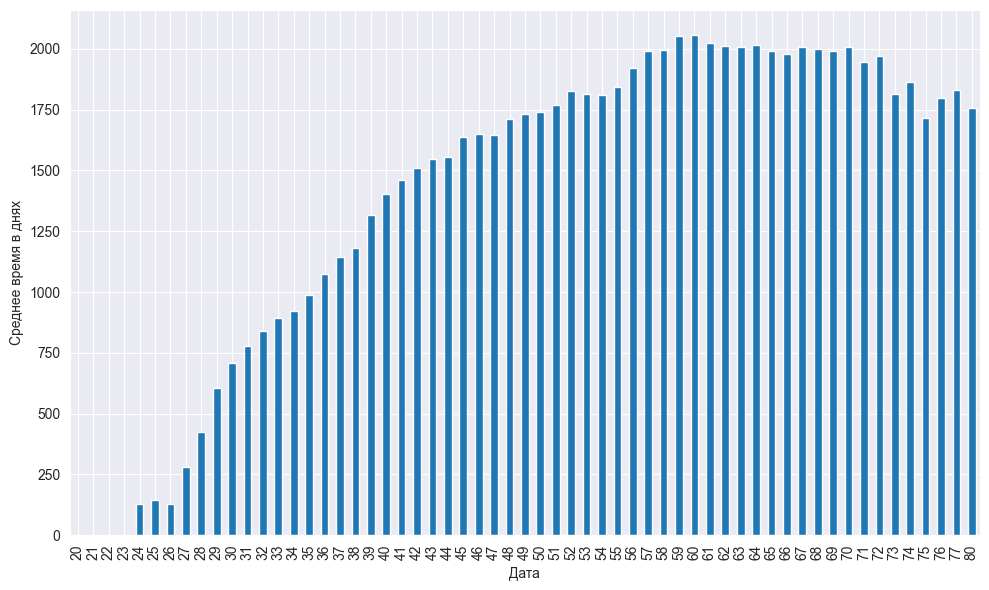

In [138]:
df_for_plot = df
df_for_plot = df.fillna({'sum_bill': 0})

print(df_for_plot['sum_bill'])
data_for_plot = df_for_plot.groupby('age')['sum_bill'].mean()
data_for_plot = exponential_smoothing(data_for_plot, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.tight_layout()
plt.show()

Index(['userid', 'complain_count', 'last_order_dt',
       'discount_purchases_count_avg', 'catalogue_purchases_count_avg',
       'store_purchases_count_avg', 'website_purchases_count_avg',
       'website_visit_count_avg', 'mobile_purchases_count_avg',
       'mobile_visit_count_avg', 'marketing_company_outcome_1',
       'marketing_company_outcome_2', 'marketing_company_outcome_3',
       'marketing_company_outcome_4', 'marketing_company_outcome_5',
       'join_datetime', 'age', 'income', 'kids', 'teenagers', 'marital',
       'education', 'join_date', 'fish', 'sweets', 'fruits', 'alcohol', 'meat',
       'vegetables', 'other', 'sum_bill', 'purchases',
       'marketing_company_outcome', 'discount_percent', 'kids_and_teenagers',
       'website_conversion', 'mobile_conversion', 'days_between'],
      dtype='object')


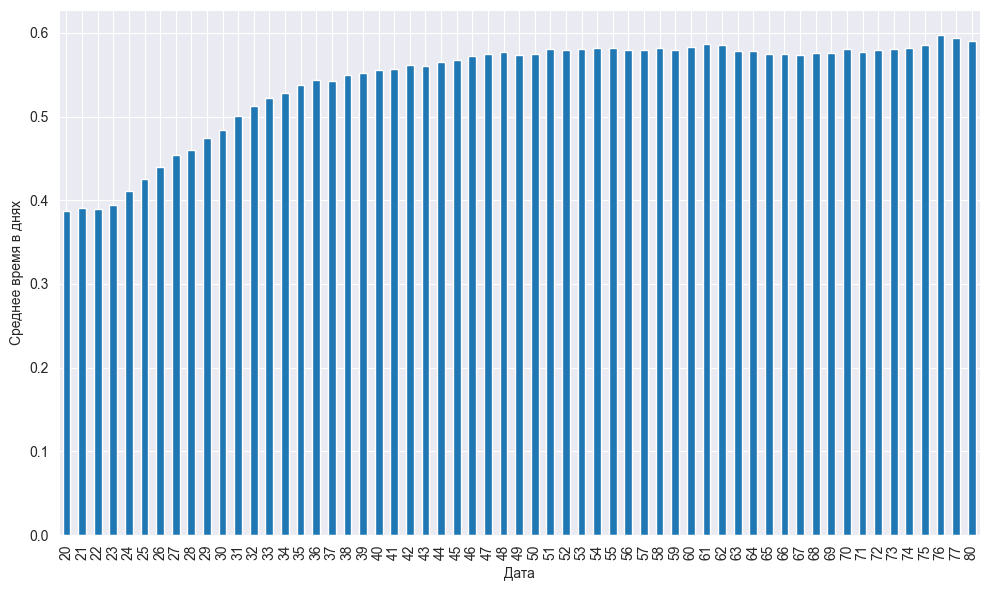

In [140]:
df_for_plot = df
print(df.columns)
data_for_plot = df_for_plot.groupby('age')['mobile_conversion'].mean()
data_for_plot = exponential_smoothing(data_for_plot, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.tight_layout()
plt.show()

In [154]:
young_df = df[df['age'] < 30]
data_for_plot = young_df.groupby('join_date').size()
data_for_plot = exponential_smoothing(data_for_plot)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Среднее время в днях')
plt.tight_layout()
plt.show()

C:\Users\merzl\AppData\Local\Temp\ipykernel_3912\680327695.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2999999999999998' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.iloc[i] = alpha * series.iloc[i] + (1 - alpha) * result.iloc[i - 1]


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

C:\Users\merzl\AppData\Local\Temp\ipykernel_3912\680327695.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.iloc[i] = alpha * series.iloc[i] + (1 - alpha) * result.iloc[i - 1]


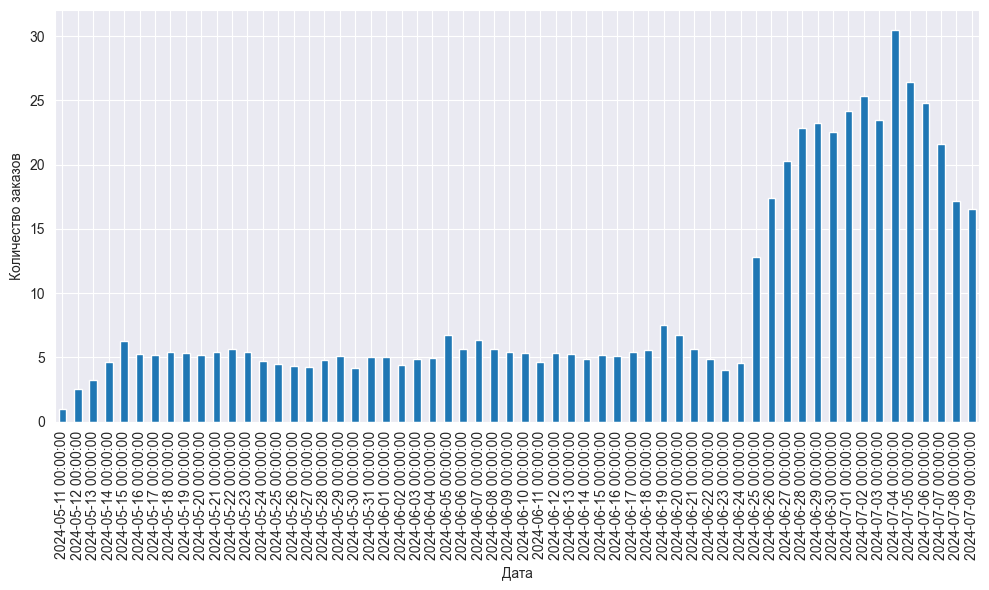

In [151]:
medium_df = df[(30 <= df['age']) & (df['age'] < 45)]
data_for_plot = medium_df.groupby('last_order_dt').size()
data_for_plot = exponential_smoothing(data_for_plot)

# Plotting
plt.figure(figsize=(10, 6))
data_for_plot.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')  
plt.tight_layout()
plt.show()